<a href="https://colab.research.google.com/github/Singular-Brain/BioLCNet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the stable version of BindsNet, the restart your run time before running the next cell

In [1]:
!pip install --upgrade matplotlib

     |████████████████████████████████| 11.2 MB 29.5 MB/s 
     |████████████████████████████████| 895 kB 64.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
!git clone https://github.com/Singular-Brain/BioLCNet
%cd BioLCNet

Cloning into 'BioLCNet'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 110 (delta 47), reused 68 (delta 21), pack-reused 0
Receiving objects: 100% (110/110), 25.03 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/BioLCNet


In [2]:
! pip install -q git+https://github.com/BindsNET/bindsnet.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 120 kB 31.9 MB/s 
     |████████████████████████████████| 1.5 MB 70.5 MB/s 
     |████████████████████████████████| 1.7 MB 51.3 MB/s 
     |████████████████████████████████| 60.4 MB 1.1 MB/s 
     |████████████████████████████████| 11.3 MB 68.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 180 kB 79.0 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import os
import numpy as np

from biolcnet import BioLCNet
from reward import DynamicDopamineInjection
from dataset import ClassSelector, load_datasets
from bindsnet.analysis.plotting import plot_locally_connected_weights
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Sized, Dict, Union
from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from torch.nn.modules.utils import _pair
from matplotlib.collections import PathCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

gpu = True
seed = 2045 # The singularity is near!

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on", device)


n_neurons = 300
# Dataset Hyperparameters
target_classes = (0,1,2)
if target_classes:
    npz_file = np.load(f'./masks/mask_{"_".join([str(i) for i in target_classes])}.npz')
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
    
else:
    mask = None
    mask_test = None
    n_classes = 10
neuron_per_class = n_neurons//n_classes


Running on cuda


#Pre-training

In [29]:
train_hparams = {
    'n_train' : 2000,
    'n_test' : 1,
    'n_val' : 1,
    'val_interval' : 200,
    'running_window_length': 1,
}

network_hparams = {
    # net structure
    'crop_size': 22,
    'neuron_per_c': neuron_per_class,
    'in_channels':1,
    'n_channels_lc': 100,
    'filter_size': 15,
    'stride': 4,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': True,
    'has_decision_period': True,
    'observation_period': 100,
    'decision_period': 100,
    'time': 256,
    'online_rewarding': False,

    # Nodes
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'nu_LC': (0.0001,0.01),
    'nu_Output':0.0,

    # weights
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type_FC': 'between_layers',
    'inh_factor_FC': 100,
    'inh_LC': True,
    'inh_factor_LC': 100,
    
    # Normalization
    'norm_factor_LC': 0.25,
    
    # clamping
    'clamp_intensity': None,

    # Save
    'save_path': "/content/drive/MyDrive/Data/LC_weights_012pth",  # Specify for saving the model (Especially for pre-training the lc layer)
    'load_path': None,
    'LC_weights_path': None, # Specify for loading the pre-trained lc weights

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': False,
}


#### These are not important for feature extraction
reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    'variant': 'scalar',
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 1.,
    'punishment_base': 1.,
    'sub_variant': 'static',
    'td_nu': 0.0005,  #RPE
    'ema_window': 10, #RPE
    }

data_hparams = { 
    'intensity': 128,
    'time': 256,
    'crop_size': 22,
    'round_input': False,
}

dataloader, val_loader, test_loader = load_datasets(data_hparams, target_classes=target_classes, mask=mask, mask_test=mask_test)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = BioLCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.testing= False
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

LC pre-trained weights not loaded. Training will be end-to-end and will take more time!
Previous model not found! Training from the beginning...



  0%|          | 0/2000 [00:00<?, ?it/s]

output tensor([7, 0, 0]) pred_label: 0 GT: 2       Test accuracy: 100.00


#visualization

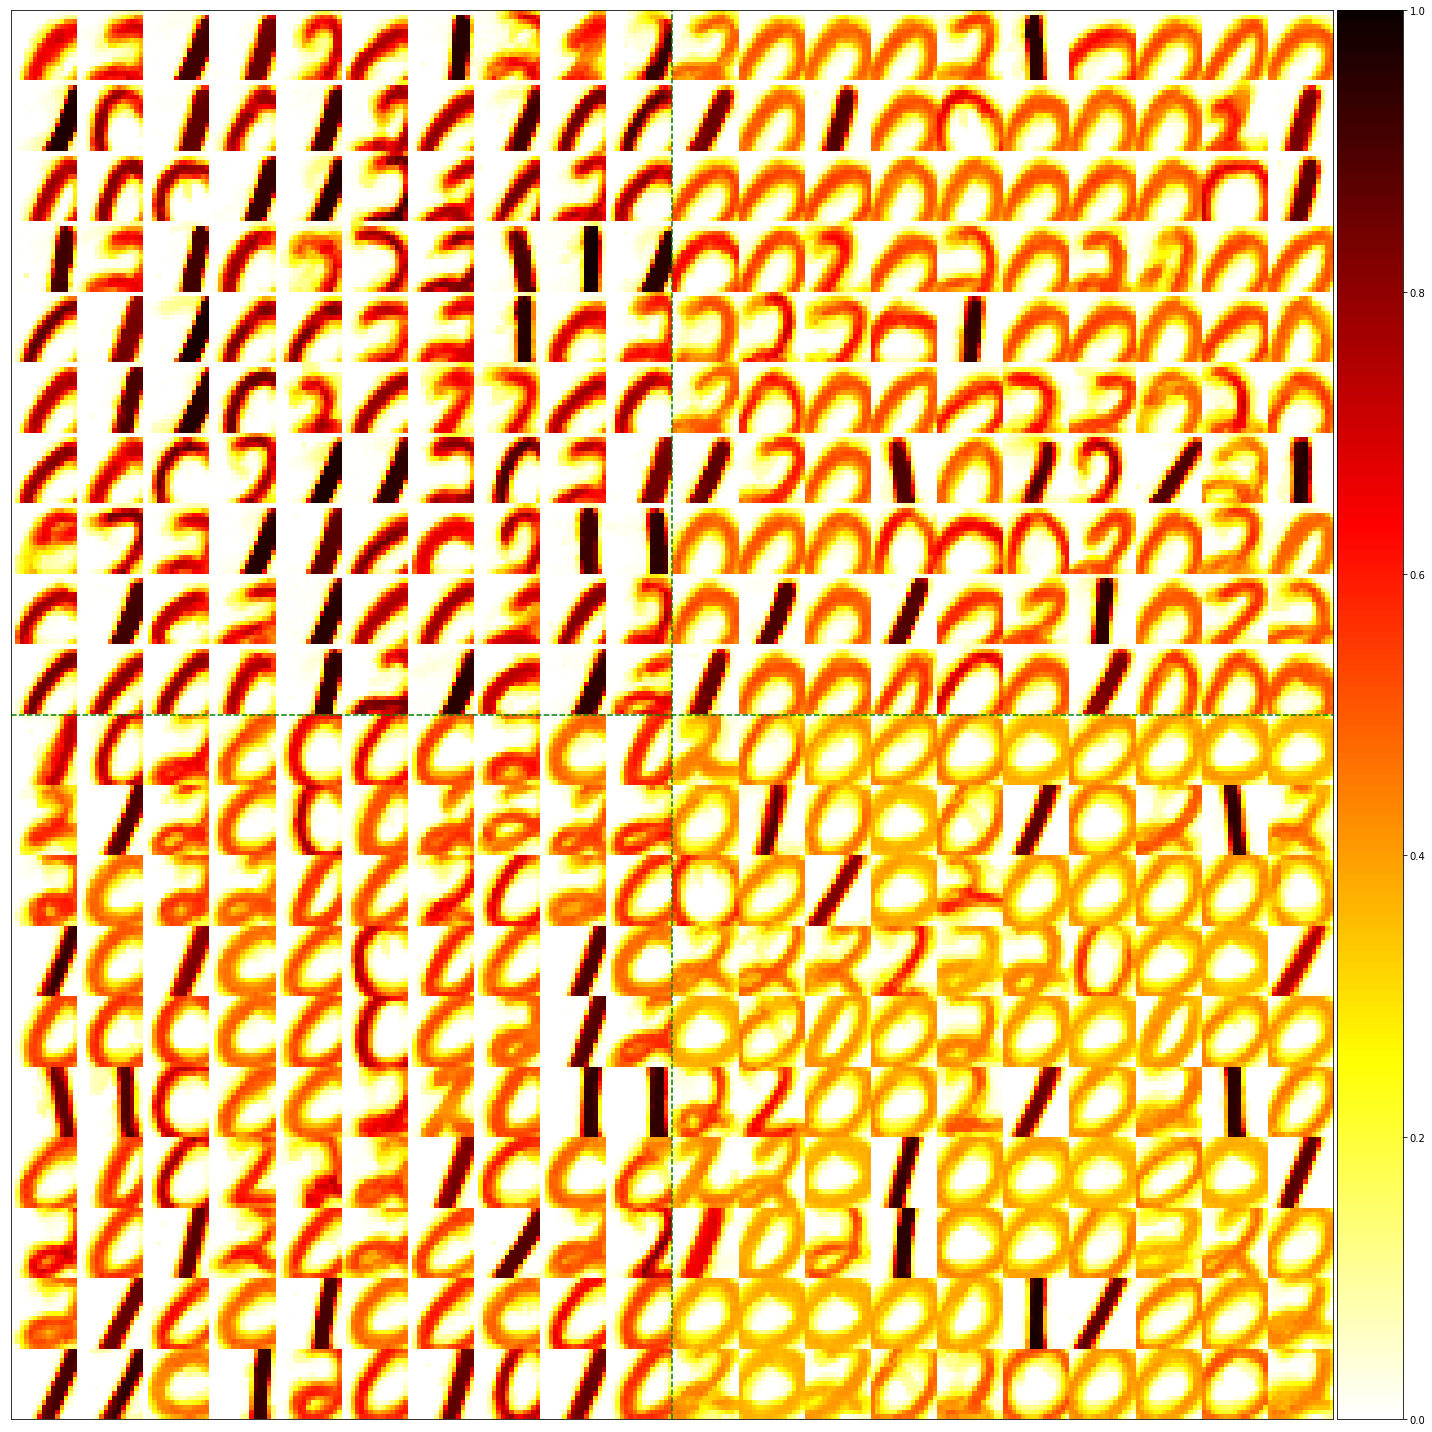

In [30]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

plot_locally_connected_weights(
    weights= net.connections[("input","main")].w,
    n_filters= hparams["n_channels_lc"],
    kernel_size= hparams["filter_size"],
    conv_size= compute_size(hparams["crop_size"], hparams["filter_size"], hparams["stride"]),
    locations= net.connections[("input","main")].locations,
    input_sqrt= hparams["crop_size"],
    wmin = 0.0,
    wmax = 1.0,
    figsize=(20, 20),
    cmap = "hot_r",)

# Training

In [ ]:
train_hparams = {
    'n_train' : 10000,
    'n_test' : 10000,
    'n_val' : 1,
    'val_interval' : 250,
    'running_window_length': 250,
}

network_hparams = {
    # net structure
    'crop_size': 22,
    'neuron_per_c': neuron_per_class,
    'in_channels':1,
    'n_channels_lc': 100,
    'filter_size': 15,
    'stride': 4,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': True,
    'has_decision_period': True,
    'observation_period': 256,
    'decision_period': 256,
    'time': 256*3,
    'online_rewarding': False,

    # Nodes
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'nu_LC': (0.0001,0.01),
    'nu_Output':0.1,

    # weights
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type_FC': 'between_layers',
    'inh_factor_FC': 100,
    'inh_LC': True,
    'inh_factor_LC': 100,
    
    # Normalization
    'norm_factor_LC': 0.25,
    
    # clamping
    'clamp_intensity': None,

    # Save
    'save_path': None,  # Specify for saving the model (Especially for pre-training the lc layer)
    'load_path': None,
    'LC_weights_path': "/content/drive/MyDrive/Data/LC_weights_012pth", #'BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_pretrained_LCweights.pth', # Specify for loading the pre-trained lc weights

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': False,
}

reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    'variant': 'scalar',
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 1.,
    'punishment_base': 1.,
    'sub_variant': 'RPE',
    'td_nu': 0.0005,  #RPE
    'ema_window': 10, #RPE
    }


data_hparams = { 
    'intensity': 128,
    'time': 256*3,
    'crop_size': 22,
    'round_input': False,
}

dataloader, val_loader, test_loader = load_datasets(data_hparams, target_classes, mask, mask_test)


hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = BioLCNet(**hparams, reward_fn = DynamicDopamineInjection, gpu = gpu)
net.testing = False
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, online_validate = False, **train_hparams)

LC pre-trained weights loaded ...
Previous model not found! Training from the beginning...



  0%|          | 0/10000 [00:00<?, ?it/s]

output tensor([  0, 321,   0]) pred_label: 1 GT: 0       

# Test

In [ ]:
### Test
data_hparams = { 
    'intensity': 128,
    'time': 256*2,
    'crop_size': 22,
    'round_input': False,
}
network_hparams['time'] = 256*2
net.time = 256*2
_, _, test_loader = load_datasets(data_hparams, target_classes=None, mask=mask, mask_test=mask_test)
net.testing = True
net.evaluate(test_loader, train_hparams['n_test'], **reward_hparams)